# **Détection d'Intrusions Réseau avec GRU Bidirectionnel (Dataset UNSW-NB15)**

Ce notebook présente la mise en œuvre d'un système de détection d'intrusions (IDS) basé sur le Deep Learning.

Nous utilisons le dataset **UNSW-NB15**, plus moderne et complexe que le KDD99, pour entraîner un réseau de neurones récurrent (RNN-GRU) capable de classifier le trafic réseau comme "Normal" ou "Attaque".

**Objectifs :**
1. Analyse exploratoire des données (EDA).
2. Prétraitement et encodage des features réseaux.
3. Construction et entraînement d'un modèle GRU.
4. Évaluation des performances (Matrice de confusion, Accuracy).

**Faite par:**
- DJILI Mohamed Amine
- El Kadiri Omar

## 1. Configuration et Importation des Données
Importation des bibliothèques nécessaires (TensorFlow, Scikit-learn, Pandas) et chargement des fichiers d'entraînement et de test.

In [32]:
import os
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Bidirectional, GRU, BatchNormalization
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from tensorflow.keras.regularizers import l2

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

train_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/ML & DL for cybersecurity/UNSW-NB15 RNN_LSTM/Dataset/UNSW_NB15_training-set.csv')
test_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/ML & DL for cybersecurity/UNSW-NB15 RNN_LSTM/Dataset/UNSW_NB15_testing-set.csv')

print("Chargement du Dataset est terminée !")

Mounted at /content/gdrive
Chargement du Dataset est terminée !


In [4]:
print(f"Taille du Training Set : {train_df.shape}")
print(f"Taille du Testing Set : {test_df.shape}")

Taille du Training Set : (175341, 45)
Taille du Testing Set : (82332, 45)


In [5]:
train_df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,252,1572.271851,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,252,2740.178955,3358.622070,1,3,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,252,8561.499023,3987.059814,2,1,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,Normal,0


## 2. Analyse Exploratoire des Données (EDA)
Avant de modéliser, nous analysons la distribution des classes et les corrélations pour comprendre la nature du trafic.
* **Équilibre des classes :** Vérification de la proportion Normal vs Attaque.
* **Types d'attaques :** Identification des menaces les plus fréquentes (Generic, Exploits, etc.).
* **Corrélations :** Analyse des relations entre les variables numériques (Heatmap).

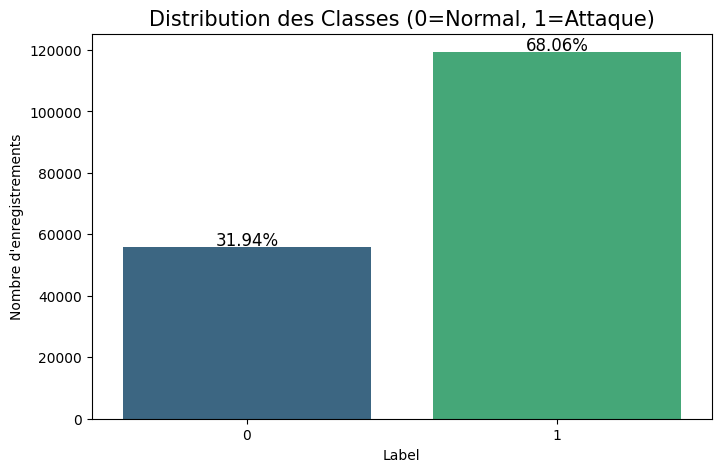

In [6]:
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=train_df, palette='viridis', hue='label', dodge=False, legend=False)
plt.title("Distribution des Classes (0=Normal, 1=Attaque)", fontsize=15)
plt.xlabel("Label")
plt.ylabel("Nombre d'enregistrements")

total = len(train_df)
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().text(
        p.get_x() + p.get_width()/2.,
        height + 500,
        '{:1.2f}%'.format(100 * height/total),
        ha="center",
        fontsize=12
    )

plt.show()

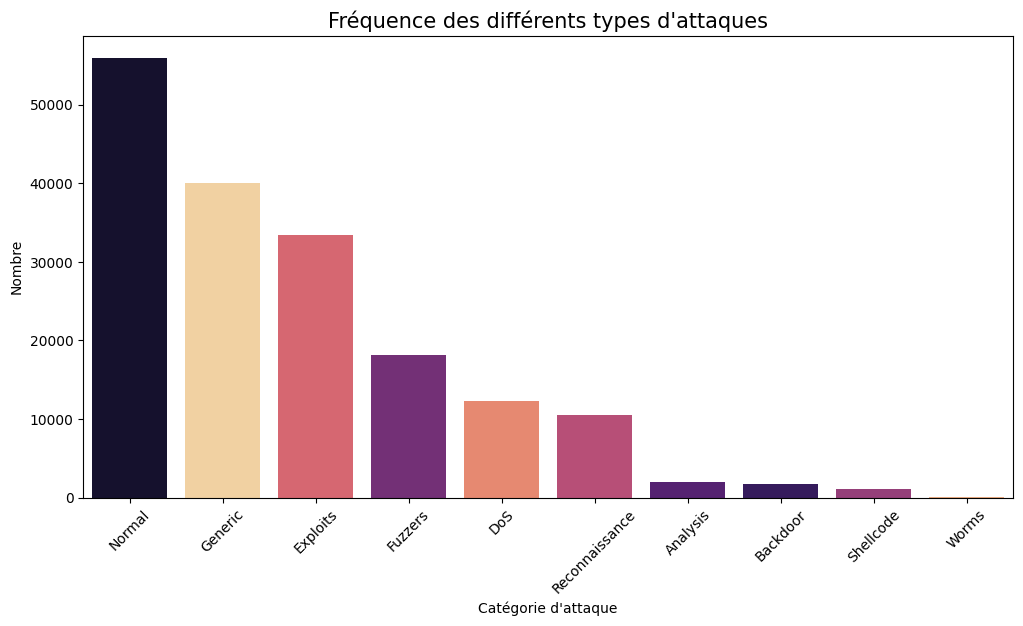

In [7]:
plt.figure(figsize=(12, 6))
order = train_df['attack_cat'].value_counts().index

sns.countplot(
    x='attack_cat',
    data=train_df,
    order=order,
    palette='magma',
    hue='attack_cat',
    dodge=False,
    legend=False
)

plt.title("Fréquence des différents types d'attaques", fontsize=15)
plt.xlabel("Catégorie d'attaque")
plt.ylabel("Nombre")
plt.xticks(rotation=45)
plt.show()

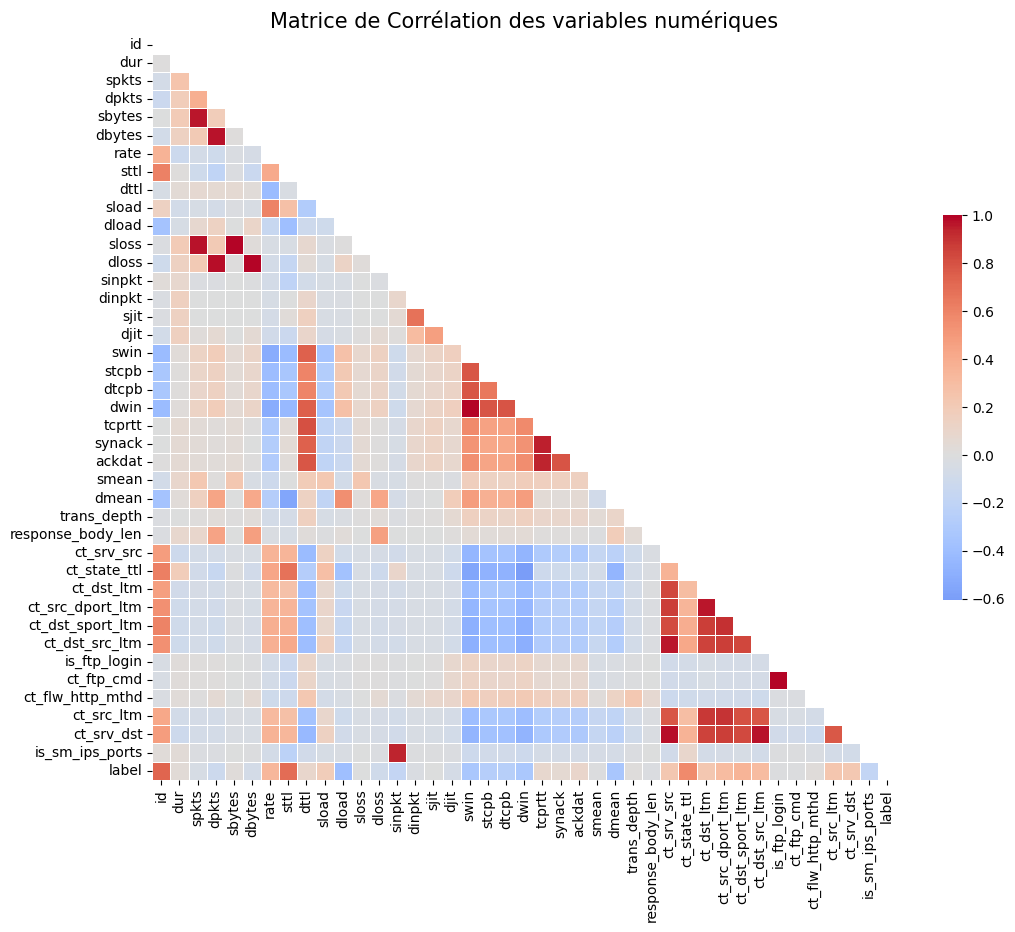

In [8]:
plt.figure(figsize=(12, 10))

numeric_cols = train_df.select_dtypes(include=['float64', 'int64'])
corr_matrix = numeric_cols.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title("Matrice de Corrélation des variables numériques", fontsize=15)
plt.show()

## 3. Nettoyage des Données (Data Cleaning)
* **Valeurs manquantes :** Vérification et gestion des `NaN`.
* **Suppression des colonnes inutiles :** L'identifiant `id` est retiré car il n'apporte aucune information contextuelle sur le trafic réseau.

In [9]:
print(f"Valeurs manquantes (NaN) dans Train : {train_df.isnull().sum().sum()}")
print(f"Valeurs manquantes (NaN) dans Test : {test_df.isnull().sum().sum()}")

Valeurs manquantes (NaN) dans Train : 0
Valeurs manquantes (NaN) dans Test : 0


In [10]:
if 'id' in train_df.columns:
  train_df = train_df.drop('id', axis=1)
  print("Colonne 'id' supprimée du Train.")

if 'id' in test_df.columns:
    test_df = test_df.drop('id', axis=1)
    print("Colonne 'id' supprimée du Test.")

Colonne 'id' supprimée du Train.
Colonne 'id' supprimée du Test.


In [11]:
cols_cat = train_df.select_dtypes(include=['object']).columns

print("---> Analyse des colonnes <---")
print(f"Nombre total de colonnes restantes : {train_df.shape[1]}")
print(f"Colonnes contenant du texte (à encoder) : {list(cols_cat)}")

print("\nExemple de valeurs dans les colonnes texte :")
print(train_df[cols_cat].head())

---> Analyse des colonnes <---
Nombre total de colonnes restantes : 44
Colonnes contenant du texte (à encoder) : ['proto', 'service', 'state', 'attack_cat']

Exemple de valeurs dans les colonnes texte :
  proto service state attack_cat
0   tcp       -   FIN     Normal
1   tcp       -   FIN     Normal
2   tcp       -   FIN     Normal
3   tcp     ftp   FIN     Normal
4   tcp       -   FIN     Normal


## 4. Encodage des Variables Catégorielles
Les modèles de Deep Learning ne traitent que des données numériques.
Les variables textuelles (`proto`, `service`, `state`) sont transformées en nombres via un **Label Encoding**.
*Note : Train et Test sont combinés temporairement pour garantir une cohérence dans l'encodage des catégories.*

In [12]:
cols_to_encode = ['proto', 'service', 'state', 'attack_cat']

# On combine Train et Test pour que l'encodeur apprenne toutes les catégories possibles
combined_df = pd.concat([train_df, test_df], axis=0)

le = LabelEncoder()

print("Début de l'encodage...")
for col in cols_to_encode:
  combined_df[col] = le.fit_transform(combined_df[col].astype(str))
  print(f" --> Colonne '{col}' encodée <--")

train_df_encoded = combined_df.iloc[:len(train_df), :]
test_df_encoded = combined_df.iloc[len(train_df):, :]
print("\nEncodage terminé !")

Début de l'encodage...
 --> Colonne 'proto' encodée <--
 --> Colonne 'service' encodée <--
 --> Colonne 'state' encodée <--
 --> Colonne 'attack_cat' encodée <--

Encodage terminé !


In [13]:
print("Types de données après encodage (Aperçu) :")
print(train_df_encoded[['proto', 'service', 'state', 'attack_cat']].head())
print("-" * 30)
print(train_df_encoded.info())

Types de données après encodage (Aperçu) :
   proto  service  state  attack_cat
0    113        0      4           6
1    113        0      4           6
2    113        0      4           6
3    113        3      4           6
4    113        0      4           6
------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 175341 entries, 0 to 175340
Data columns (total 44 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   dur                175341 non-null  float64
 1   proto              175341 non-null  int64  
 2   service            175341 non-null  int64  
 3   state              175341 non-null  int64  
 4   spkts              175341 non-null  int64  
 5   dpkts              175341 non-null  int64  
 6   sbytes             175341 non-null  int64  
 7   dbytes             175341 non-null  int64  
 8   rate               175341 non-null  float64
 9   sttl               175341 non-null  int64  
 10  dttl 

In [14]:
# On retire 'label' (la cible) et 'attack_cat' (pour éviter la fuite d'info)
X_train = train_df_encoded.drop(['label', 'attack_cat'], axis=1)
y_train = train_df_encoded['label']

X_test = test_df_encoded.drop(['label', 'attack_cat'], axis=1)
y_test = test_df_encoded['label']

print("Séparation X/y terminée.")

Séparation X/y terminée.


### **Suppression des features trop corrélées (Réduction de bruit)**

In [15]:
corr_matrix = combined_df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print(f"Colonnes supprimées (trop corrélées) : {to_drop}")
combined_df.drop(to_drop, axis=1, inplace=True)

Colonnes supprimées (trop corrélées) : ['sbytes', 'dbytes', 'sloss', 'dloss', 'dwin', 'ct_src_dport_ltm', 'ct_dst_src_ltm', 'ct_ftp_cmd', 'ct_srv_dst']


## 5. Sélection des Features et Normalisation
* **Séparation X/y :** Isolement des features (X) et de la cible (y). La colonne `attack_cat` est retirée pour la classification binaire.
* **Mise à l'échelle (Scaling) :** Utilisation de `StandardScaler` pour normaliser toutes les valeurs entre 0 et 1, ce qui est crucial pour la convergence rapide du LSTM.

In [16]:
scaler = StandardScaler()

print("---> Début de la normalisation... <---")
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Normalisation terminée !!")

---> Début de la normalisation... <---
Normalisation terminée !!


In [17]:
print(f"Forme de X_train_scaled : {X_train_scaled.shape}")
print(f"Forme de y_train : {y_train.shape}")

Forme de X_train_scaled : (175341, 42)
Forme de y_train : (175341,)


## 6. Formatage pour GRU (Reshaping)
Les couches GRU attendent une entrée en 3 dimensions : `(Samples, TimeSteps, Features)`.
Nous redimensionnons les données matricielles 2D en séquences 3D.

In [18]:
def create_sequences(X, y, time_steps=10):
  Xs, ys = [], []
  for i in range(len(X) - time_steps):
      Xs.append(X[i:(i + time_steps)])
      ys.append(y[i + time_steps])
  return np.array(Xs), np.array(ys)

TIME_STEPS = 10

# Création des séquences
print("Création des séquences temporelles...")
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train.values, TIME_STEPS)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test.values, TIME_STEPS)

print(f"Nouvelle forme X_train : {X_train_seq.shape}")

Création des séquences temporelles...
Nouvelle forme X_train : (175331, 10, 42)


## 7. Architecture du Modèle GRU
Construction du réseau de neurones avec Keras :
* **Couches GRU :** Pour capturer les dépendances temporelles et séquentielles du trafic.
* **Dropout (0.5) :** Pour prévenir le surapprentissage (Overfitting).
* **Couche Dense (Sigmoid) :** Pour la classification binaire finale (probabilité d'attaque).

In [19]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))
print(f"Poids appliqués : {class_weight_dict}")

Poids appliqués : {0: np.float64(1.565544642857143), 1: np.float64(0.734621798040908)}


In [20]:
model = Sequential()
model.add(Bidirectional(GRU(64, return_sequences=True, kernel_regularizer=l2(0.001)), input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(32, return_sequences=False, kernel_regularizer=l2(0.001))))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
# Résumé de l'architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 10, 128)        │        41,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 10, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        31,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,409 (286.75 KB)

 Trainable params: 73,025 (285.25 KB)

 Non-trainable params: 384 (1.50 KB)

## 8. Entraînement du Modèle
Lancement de l'apprentissage supervisé sur le jeu d'entraînement, avec validation simultanée sur le jeu de test pour surveiller la convergence.

In [22]:
# 1. Définition des Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=0.00001
)

In [23]:
history = model.fit(
  X_train_seq,
  y_train_seq,
  epochs=40,
  batch_size=64,
  validation_data=(X_test_seq, y_test_seq),
  class_weight=class_weight_dict,
  callbacks=[early_stop, reduce_lr]
)

Epoch 1/40
2740/2740 ━━━━━━━━━━━━━━━━━━━━ 47s 14ms/step - accuracy: 0.9165 - loss: 0.3775 - val_accuracy: 0.9633 - val_loss: 0.1475 - learning_rate: 0.0010
Epoch 2/40
2740/2740 ━━━━━━━━━━━━━━━━━━━━ 36s 13ms/step - accuracy: 0.9400 - loss: 0.1764 - val_accuracy: 0.9621 - val_loss: 0.1367 - learning_rate: 0.0010
Epoch 3/40
2740/2740 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - accuracy: 0.9414 - loss: 0.1637 - val_accuracy: 0.9632 - val_loss: 0.1462 - learning_rate: 0.0010
Epoch 4/40
2740/2740 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - accuracy: 0.9424 - loss: 0.1587 - val_accuracy: 0.9431 - val_loss: 0.1573 - learning_rate: 0.0010
Epoch 5/40
2740/2740 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - accuracy: 0.9435 - loss: 0.1491 - val_accuracy: 0.9289 - val_loss: 0.1758 - learning_rate: 5.0000e-04


## 9. Évaluation des Performances
Analyse finale de la qualité du modèle :
1.  **Courbes d'apprentissage :** Visualisation de l'évolution de la perte (Loss) et de la précision (Accuracy).
2.  **Matrice de Confusion :** Détail des Vrais Positifs, Faux Positifs, Vrais Négatifs et Faux Négatifs.
3.  **Rapport de Classification :** Précision, Rappel et F1-Score pour chaque classe.

In [24]:
# Récupération des données de l'historique
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

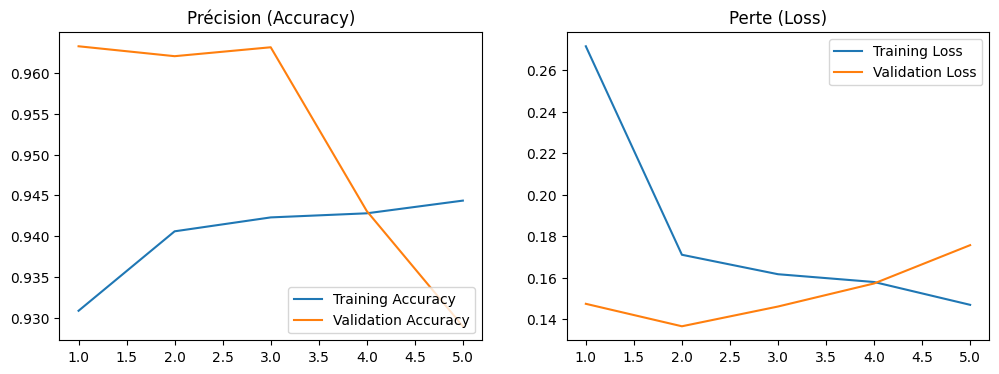

In [25]:
# Création du graphique
plt.figure(figsize=(12, 4))

# Courbe de Précision (Accuracy)
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Précision (Accuracy)')
plt.legend(loc='lower right')

# Courbe de Perte (Loss)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Perte (Loss)')
plt.legend(loc='upper right')

plt.show()

In [29]:
print("Calcul des prédictions...")
y_pred = model.predict(X_test_seq)
y_pred_binary = (y_pred > 0.5).astype(int)

Calcul des prédictions...
2573/2573 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step


### **Matrice de confusion**

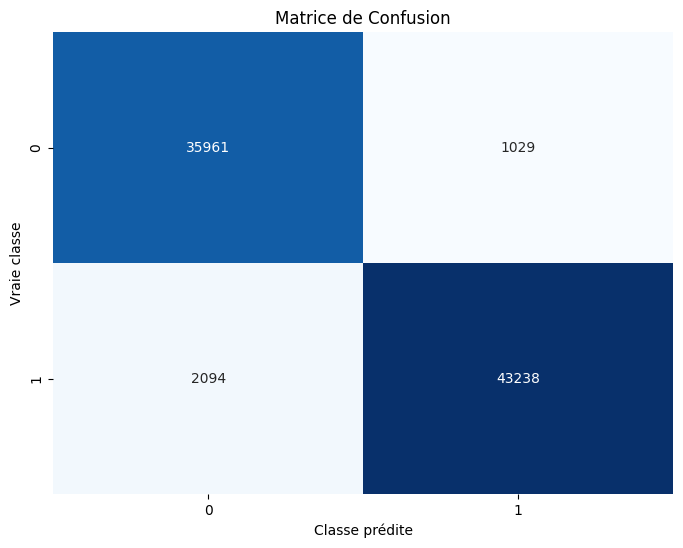

In [30]:
cm = confusion_matrix(y_test_seq, y_pred_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matrice de Confusion')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.show()

### **Rapport complet**

In [31]:
print(classification_report(y_test_seq, y_pred_binary, target_names=['Normal', 'Attaque']))

              precision    recall  f1-score   support

      Normal       0.94      0.97      0.96     36990
     Attaque       0.98      0.95      0.97     45332

    accuracy                           0.96     82322
   macro avg       0.96      0.96      0.96     82322
weighted avg       0.96      0.96      0.96     82322



### **Sauvegarder le model & le Scaler**

In [33]:
MODEL_SAVE_PATH = '/content/gdrive/MyDrive/Colab Notebooks/ML & DL for cybersecurity/UNSW-NB15 RNN_LSTM/model_files'

if not os.path.exists(MODEL_SAVE_PATH):
    os.makedirs(MODEL_SAVE_PATH)
    print(f"Dossier créé : {MODEL_SAVE_PATH}")

# ---> Sauvegarde du Modèle <---
model_path = os.path.join(MODEL_SAVE_PATH, 'ids_gru_model.keras')
model.save(model_path)
print(f"Modèle sauvegardé ici : {model_path}")

# ---> Sauvegarde du Scaler <---
scaler_path = os.path.join(MODEL_SAVE_PATH, 'scaler_std.pkl')
joblib.dump(scaler, scaler_path)
print(f"Scaler sauvegardé ici : {scaler_path}")

Dossier créé : /content/gdrive/MyDrive/Colab Notebooks/ML & DL for cybersecurity/UNSW-NB15 RNN_LSTM/model_files
Modèle sauvegardé ici : /content/gdrive/MyDrive/Colab Notebooks/ML & DL for cybersecurity/UNSW-NB15 RNN_LSTM/model_files/ids_gru_model.keras
Scaler sauvegardé ici : /content/gdrive/MyDrive/Colab Notebooks/ML & DL for cybersecurity/UNSW-NB15 RNN_LSTM/model_files/scaler_std.pkl
